In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from keras import layers, models
import numpy as np
import datetime
#import capsnet
from SegCaps import capsule_layers
import dataset
import model_functions as mf
import audio_functions as af

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'


Using TensorFlow backend.


In [2]:
#  Set other variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=2
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 10
mag_phase = True

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

In [3]:
class SegCaps_CapsNetBasic(object):
    
    def __init__(self, mixed_mag, mixed_phase, voice_mag, is_training, reuse=True, name='SegCaps_CapsNetBasic'):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.mixed_phase = mixed_phase
            self.voice_mag = voice_mag
            
            with tf.variable_scope('Convolution'):
                conv1 = mf.conv(mixed_mag, filters=256, kernel_size=5, stride=(1, 1))
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = conv1.get_shape()
                conv1 = layers.Reshape((H.value, W.value, 1, C.value))(conv1)
                #conv1 = tf.expand_dims(conv1, 2)
                self.conv1 = conv1
            
            with tf.variable_scope('Primary_Caps'):
                primary_caps = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                               routings=1, name='primarycaps')(conv1)
                self.primary_caps = primary_caps
                
            with tf.variable_scope('Seg_Caps'):
                seg_caps = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(primary_caps)
                self.seg_caps = seg_caps
            
            with tf.variable_scope('Mask'):
                mask = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=1, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(seg_caps)
                self.voice_mask = tf.squeeze(mask,-1)
            
            self.gen_voice = self.voice_mask * mixed_mag
            self.cost = mf.l1_loss(self.gen_voice, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

In [4]:
class conv_net(object):
    def __init__(self, mixed_mag, mixed_phase, voice_mag, is_training, reuse=None, name='SegCaps_CapsNetBasic'):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.mixed_phase = mixed_phase
            self.voice_mag = voice_mag
            
            with tf.variable_scope('Convolution'):
                net = mf.relu(mixed_mag)
                net = mf.conv(net, filters=128, kernel_size=5, stride=(1, 1))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.conv1 = net
            
            with tf.variable_scope('Primary_Caps'):
                net = mf.relu(net)
                net = mf.conv(net, filters=128, kernel_size=5, stride=(1, 1))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.primary_caps = net
                
            with tf.variable_scope('Seg_Caps'):
                net = mf.relu(net)
                net = mf.conv(net, filters=16, kernel_size=5, stride=(1, 1))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.seg_caps = net
            
            with tf.variable_scope('Mask'):
                net = mf.relu(net)
                net = mf.conv(mixed_mag, filters=1, kernel_size=5, stride=(1, 1))
                self.voice_mask = net
            
            self.gen_voice = self.voice_mask * mixed_mag
            self.cost = mf.l1_loss(self.gen_voice, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

In [5]:
class UNetModel(object):
    """
    Top level U-Net object.
    Attributes:
        mixed_mag: Input placeholder for magnitude spectrogram of mixed signals (voice plus background noise) - X
        voice_mag: Input placeholder for magnitude spectrogram of isolated voice signal - Y
        mixed_phase: Input placeholder for phase spectrogram of mixed signals (voice plus background noise)
        mixed_audio: Input placeholder for waveform audio of mixed signals (voice plus background noise)
        voice_audio: Input placeholder for waveform audio of isolated voice signal
        variant: The type of U-Net model (Normal convolutional or capsule based)
        is_training: Boolean - should the model be trained on the current input or not
        name: Model instance name
    """
    def __init__(self, mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, variant, is_training, name):
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.voice_mag = voice_mag
            self.mixed_phase = mixed_phase
            self.mixed_audio = mixed_audio
            self.voice_audio = voice_audio
            self.variant = variant
            self.is_training = is_training

            self.voice_mask_unet = UNet(mixed_mag, variant, is_training=is_training, reuse=False, name='voice-mask-unet')

            self.voice_mask = self.voice_mask_unet.output

            self.gen_voice = self.voice_mask * mixed_mag

            self.pw_cost = mf.pw_l1_loss(self.gen_voice, voice_mag)
            self.cost = tf.reduce_mean(self.pw_cost)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.pw_cost)


class UNet(object):

    def __init__(self, input_tensor, variant, is_training, reuse, name):
        with tf.variable_scope(name, reuse=reuse):
            self.variant = variant

            if self.variant == 'unet':
                self.encoder = UNetEncoder(input_tensor, is_training, reuse)
                self.decoder = UNetDecoder(self.encoder.output, self.encoder, is_training, reuse)
            elif self.variant == 'capsunet':
                self.encoder = alt_CapsUNetEncoder(input_tensor, is_training, reuse)
                self.decoder = alt_CapsUNetDecoder(self.encoder.output, self.encoder, is_training, reuse)

            self.output = mf.tanh(self.decoder.output) / 2 + .5

class UNetEncoder(object):
    """
    The down-convolution side of a convoltional U-Net model.
    """

    def __init__(self, input_tensor, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('encoder'):
            with tf.variable_scope('layer-1'):
                net = mf.conv(net, filters=16, kernel_size=5, stride=(2, 2))
                self.l1 = net

            with tf.variable_scope('layer-2'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l2 = net

            with tf.variable_scope('layer-3'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l3 = net

            with tf.variable_scope('layer-4'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l4 = net

            with tf.variable_scope('layer-5'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l5 = net

            with tf.variable_scope('layer-6'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=512, kernel_size=5, stride=(2, 2))

            self.output = net


class UNetDecoder(object):
    """
    The up-convolution side of a convolutional U-Net model
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor

        with tf.variable_scope('decoder'):
            with tf.variable_scope('layer-1'):
                net = mf.relu(net)
                net = mf.deconv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-2'):
                net = mf.relu(mf.concat(net, encoder.l5))
                net = mf.deconv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-3'):
                net = mf.relu(mf.concat(net, encoder.l4))
                net = mf.deconv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-4'):
                net = mf.relu(mf.concat(net, encoder.l3))
                net = mf.deconv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-5'):
                net = mf.relu(mf.concat(net, encoder.l2))
                net = mf.deconv(net, filters=16, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-6'):
                net = mf.relu(mf.concat(net, encoder.l1))
                net = mf.deconv(net, filters=1, kernel_size=5, stride=(2, 2))

            self.output = net

            
class CapsUNetEncoder(object):
    """
    The down-convolutional side of a capsule based U-Net model (based on SegCaps R3 model).
    """
    def __init__(self, input_tensor, is_training, reuse):
        #net = layers.Input(shape=input_tensor)
        net = input_tensor
        with tf.variable_scope('Encoder'):
            with tf.variable_scope('Convolution'):
                # Layer 1: A conventional Conv2D layer
                net = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(net)
                self.conv1 = net
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = net.get_shape()
                net = layers.Reshape((H.value, W.value, 1, C.value))(net)
                

            # Layer 1: Primary Capsule: Conv cap with routing 1
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=8, strides=2, padding='same',
                                                routings=1, name='primarycaps')(net)
            self.primary_caps = net

            # Layer 2: Convolutional Capsules
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=8, strides=2, padding='same',
                                                  routings=3, name='conv_cap_2')(net)
            self.conv_cap_2 = net

            # Layer 3: Convolutional Capsules
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=16, strides=2, padding='same',
                                                  routings=3, name='conv_cap_3')(net)
            self.conv_cap_3 = net

            # Layer 4: Convolutional Capsules
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=2, padding='same',
                                                  routings=3, name='conv_cap_4')(net)

            self.output = net


class CapsUNetDecoder(object):
    """
    The up-convolutional side of a capsule based U-Net model.
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('Decoder'):
                # Layer 1 Up: Deconvolutional capsules, skip connection, convolutional capsules
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=16, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_1')(net)
            self.upcap_1 = net

            net = layers.Concatenate(axis=-2, name='skip_1')([net, encoder.conv_cap_3])

            # Layer 2 Up: Deconvolutional capsules, skip connection, convolutional capsules
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=8, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_2')(net)
            self.upcap_2 = net

            net = layers.Concatenate(axis=-2, name='skip_2')([net, encoder.conv_cap_2])

            # Layer 3 Up: Deconvolutional capsules, skip connection
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=8, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_3')(net)
            self.upcap_3 = net

            net = layers.Concatenate(axis=-2, name='skip_3')([net, encoder.primary_caps])
            
            # Layer 4: Reconstruction - Convolutional Capsule: 1x1, 3x conventional Conv2D layers
            #net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
            #                                      routings=3, name='seg_caps')(net)
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=1, num_atoms=16, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_4')(net)
            self.upcap_4 = net

            _, H, W, C, D = net.get_shape()

            net = layers.Reshape((H.value, W.value, D.value))(net)
            net = layers.Concatenate(axis=-1, name='skip_4')([net, encoder.conv1])

            net = layers.Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='relu', name='recon_1')(net)

            net = layers.Conv2D(filters=128, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='relu', name='recon_2')(net)

            net = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='sigmoid', name='out_recon')(net)

            self.output = net

In [6]:
#tf.reset_default_graph()
#model = SegCaps_CapsNetBasic(mixed_mag, mixed_phase, voice_mag, is_training=False)
model = conv_net(mixed_mag, mixed_phase, voice_mag, is_training=False)
#model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'capsunet', is_training=True, name='R3_CapsNet')
#model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'unet', is_training=True, name='R3_CapsNet')

### Basic Caps Net - Layer Dimensions

In [58]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.primary_caps.get_shape().as_list(),
      '\nSeg Caps: ',model.seg_caps.get_shape().as_list(),
      '\nRecontruction: ',model.gen_voice.get_shape().as_list())

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 256] 
Primary Caps:  [None, 256, 512, 256] 
Seg Caps:  [None, 256, 512, 16] 
Recontruction:  [None, 256, 512, 1]


Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 1, 256] 
Primary Caps:  [None, 256, 512, 8, 32] 
Seg Caps:  [None, 256, 512, 1, 16] 
Recontruction:  [None, 256, 512, 1]


### R3 Caps Net - Layer Dimensions

In [15]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.voice_mask_unet.encoder.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.voice_mask_unet.encoder.primary_caps.get_shape().as_list(),
      '\nConv Caps 2: ',model.voice_mask_unet.encoder.conv_cap_2.get_shape().as_list(),
      '\nConv Caps 3: ',model.voice_mask_unet.encoder.conv_cap_3.get_shape().as_list(),
      '\nConv Caps 4 (output): ',model.voice_mask_unet.encoder.output.get_shape().as_list(),
      
      '\n\nUp Caps 1: ',model.voice_mask_unet.decoder.upcap_1.get_shape().as_list(),
      '\nUp Caps 2: ',model.voice_mask_unet.decoder.upcap_2.get_shape().as_list(),
      '\nUp Caps 3: ',model.voice_mask_unet.decoder.upcap_3.get_shape().as_list(),
      '\nUp Caps 4: ',model.voice_mask_unet.decoder.upcap_4.get_shape().as_list(),
      '\nReconstruction (output): ',model.voice_mask_unet.decoder.output.get_shape().as_list()
      )

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 16] 
Primary Caps:  [None, 128, 256, 2, 8] 
Conv Caps 2:  [None, 64, 128, 4, 8] 
Conv Caps 3:  [None, 32, 64, 8, 16] 
Conv Caps 4 (output):  [None, 16, 32, 8, 32] 

Up Caps 1:  [None, 32, 64, 8, 16] 
Up Caps 2:  [None, 64, 128, 4, 8] 
Up Caps 3:  [None, 128, 256, 2, 8] 
Up Caps 4:  [None, 256, 512, 1, 16] 
Reconstruction (output):  [None, 256, 512, 1]


In [7]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())
sess.run(pipe.initializer)

In [78]:
mix, phase, voice, mask = sess.run([model.mixed_mag, model.mixed_phase, model.voice_mag, model.voice_mask])

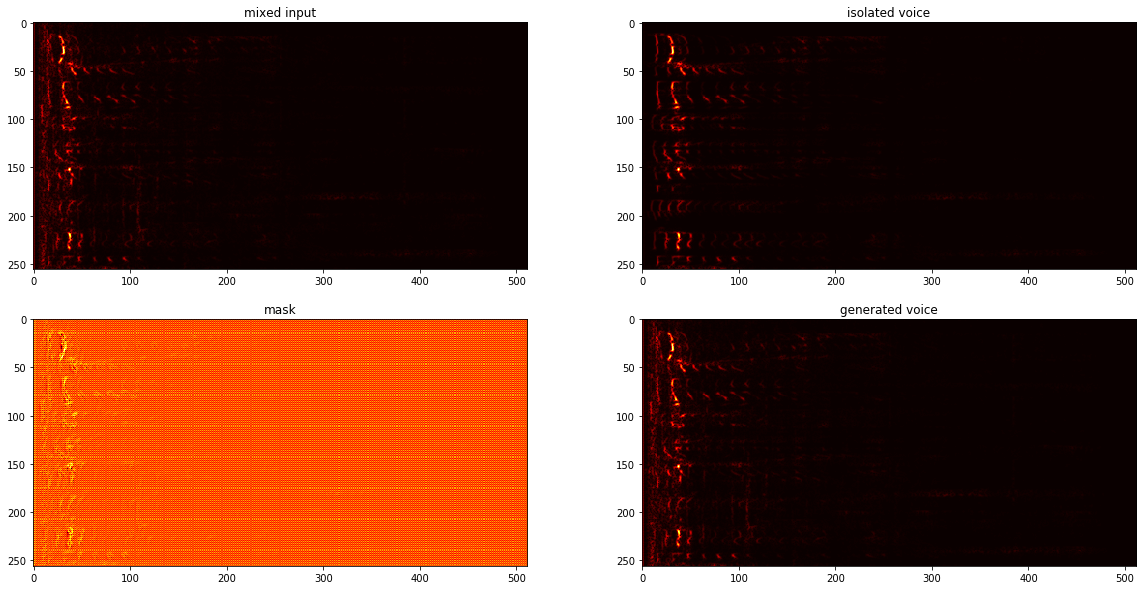

In [79]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [8]:
print('start: {}'.format(datetime.datetime.now()))
epochs = 1000
epoch = 0
epoch_cost = []
i = 0
while epoch < epochs:
    try:
        _, mix, phase, voice, mask, cost = sess.run([model.train_op, model.mixed_mag, model.mixed_phase, 
                                                     model.voice_mag, model.voice_mask, model.cost])

        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.datetime.now()))

start: 2018-10-24 19:04:37.647752
Epoch 0 finished. Mean cost = 0.0039760767947882416
Epoch 1 finished. Mean cost = 0.003966474276967347
Epoch 2 finished. Mean cost = 0.003956769794846575
Epoch 3 finished. Mean cost = 0.003947124269325286
Epoch 4 finished. Mean cost = 0.00393762736581266
Epoch 5 finished. Mean cost = 0.003928207427573701
Epoch 6 finished. Mean cost = 0.003919094448376979
Epoch 7 finished. Mean cost = 0.00391014248598367
Epoch 8 finished. Mean cost = 0.003901456446490354
Epoch 9 finished. Mean cost = 0.00389300306327641
Epoch 10 finished. Mean cost = 0.003884797433221882
Epoch 11 finished. Mean cost = 0.003876849974039942
Epoch 12 finished. Mean cost = 0.0038691355811002162
Epoch 13 finished. Mean cost = 0.0038616468298381993
Epoch 14 finished. Mean cost = 0.0038543516832093396
Epoch 15 finished. Mean cost = 0.0038472788903163744
Epoch 16 finished. Mean cost = 0.00384036511018434
Epoch 17 finished. Mean cost = 0.003833630730191039
Epoch 18 finished. Mean cost = 0.003827

Epoch 155 finished. Mean cost = 0.003405618279551466
Epoch 156 finished. Mean cost = 0.003403825072014028
Epoch 157 finished. Mean cost = 0.0034020429583195644
Epoch 158 finished. Mean cost = 0.0034002767820145536
Epoch 159 finished. Mean cost = 0.003398517725581769
Epoch 160 finished. Mean cost = 0.0033967698140428488
Epoch 161 finished. Mean cost = 0.0033950337662970948
Epoch 162 finished. Mean cost = 0.0033933084772362664
Epoch 163 finished. Mean cost = 0.0033915967907665705
Epoch 164 finished. Mean cost = 0.0033898941625022526
Epoch 165 finished. Mean cost = 0.0033882041949868562
Epoch 166 finished. Mean cost = 0.0033865260325572984
Epoch 167 finished. Mean cost = 0.003384861279933137
Epoch 168 finished. Mean cost = 0.003383206338869661
Epoch 169 finished. Mean cost = 0.0033815638997646814
Epoch 170 finished. Mean cost = 0.0033799311772468145
Epoch 171 finished. Mean cost = 0.00337831289372082
Epoch 172 finished. Mean cost = 0.0033767060532821397
Epoch 173 finished. Mean cost = 0.0

Epoch 309 finished. Mean cost = 0.0032378177639217146
Epoch 310 finished. Mean cost = 0.003237200188794895
Epoch 311 finished. Mean cost = 0.003236587229035556
Epoch 312 finished. Mean cost = 0.00323597505144156
Epoch 313 finished. Mean cost = 0.0032353680180445027
Epoch 314 finished. Mean cost = 0.0032347646423630297
Epoch 315 finished. Mean cost = 0.0032341637958100515
Epoch 316 finished. Mean cost = 0.0032335671850359684
Epoch 317 finished. Mean cost = 0.0032329733865687025
Epoch 318 finished. Mean cost = 0.0032323830235504243
Epoch 319 finished. Mean cost = 0.003231797392218141
Epoch 320 finished. Mean cost = 0.003231213893886435
Epoch 321 finished. Mean cost = 0.0032306342455124632
Epoch 322 finished. Mean cost = 0.0032300580083897148
Epoch 323 finished. Mean cost = 0.00322948572539184
Epoch 324 finished. Mean cost = 0.0032289153376164345
Epoch 325 finished. Mean cost = 0.003228350072682041
Epoch 326 finished. Mean cost = 0.003227785543826286
Epoch 327 finished. Mean cost = 0.0032

Epoch 462 finished. Mean cost = 0.0031728431331013887
Epoch 463 finished. Mean cost = 0.003172554081438334
Epoch 464 finished. Mean cost = 0.003172266865249283
Epoch 465 finished. Mean cost = 0.003171980118702761
Epoch 466 finished. Mean cost = 0.0031716950136043403
Epoch 467 finished. Mean cost = 0.0031714124392129036
Epoch 468 finished. Mean cost = 0.003171129261197121
Epoch 469 finished. Mean cost = 0.0031708473815245833
Epoch 470 finished. Mean cost = 0.0031705668027020373
Epoch 471 finished. Mean cost = 0.003170287306815133
Epoch 472 finished. Mean cost = 0.0031700089106229913
Epoch 473 finished. Mean cost = 0.0031697330175101254
Epoch 474 finished. Mean cost = 0.003169456418505625
Epoch 475 finished. Mean cost = 0.0031691813766134575
Epoch 476 finished. Mean cost = 0.0031689074089598355
Epoch 477 finished. Mean cost = 0.0031686348170353778
Epoch 478 finished. Mean cost = 0.003168363272385489
Epoch 479 finished. Mean cost = 0.0031680926962872036
Epoch 480 finished. Mean cost = 0.0

Epoch 616 finished. Mean cost = 0.003139207144969745
Epoch 617 finished. Mean cost = 0.00313904210435329
Epoch 618 finished. Mean cost = 0.0031388780518144563
Epoch 619 finished. Mean cost = 0.0031387141309378126
Epoch 620 finished. Mean cost = 0.0031385507504343266
Epoch 621 finished. Mean cost = 0.003138387889580328
Epoch 622 finished. Mean cost = 0.0031382256385572792
Epoch 623 finished. Mean cost = 0.003138064229129575
Epoch 624 finished. Mean cost = 0.003137902923449874
Epoch 625 finished. Mean cost = 0.003137742091764729
Epoch 626 finished. Mean cost = 0.0031375821308489813
Epoch 627 finished. Mean cost = 0.0031374222521112554
Epoch 628 finished. Mean cost = 0.0031372640322633264
Epoch 629 finished. Mean cost = 0.0031371050628848257
Epoch 630 finished. Mean cost = 0.00313694692761438
Epoch 631 finished. Mean cost = 0.0031367899570761463
Epoch 632 finished. Mean cost = 0.003136632294580929
Epoch 633 finished. Mean cost = 0.0031364754309484073
Epoch 634 finished. Mean cost = 0.0031

Epoch 770 finished. Mean cost = 0.003118788646703197
Epoch 771 finished. Mean cost = 0.00311868189685674
Epoch 772 finished. Mean cost = 0.00311857568236239
Epoch 773 finished. Mean cost = 0.0031184696902831397
Epoch 774 finished. Mean cost = 0.00311836396974902
Epoch 775 finished. Mean cost = 0.003118258321204117
Epoch 776 finished. Mean cost = 0.003118152998296719
Epoch 777 finished. Mean cost = 0.003118047956197707
Epoch 778 finished. Mean cost = 0.0031179433051300677
Epoch 779 finished. Mean cost = 0.0031178391004243913
Epoch 780 finished. Mean cost = 0.0031177353299915713
Epoch 781 finished. Mean cost = 0.003117631791311952
Epoch 782 finished. Mean cost = 0.003117528001779017
Epoch 783 finished. Mean cost = 0.0031174244860434257
Epoch 784 finished. Mean cost = 0.0031173214269505376
Epoch 785 finished. Mean cost = 0.003117218654325502
Epoch 786 finished. Mean cost = 0.003117116287663068
Epoch 787 finished. Mean cost = 0.003117013960689079
Epoch 788 finished. Mean cost = 0.003116911

Epoch 924 finished. Mean cost = 0.003105052950766844
Epoch 925 finished. Mean cost = 0.0031049783601069555
Epoch 926 finished. Mean cost = 0.0031049038810472625
Epoch 927 finished. Mean cost = 0.003104829426166393
Epoch 928 finished. Mean cost = 0.0031047551052101495
Epoch 929 finished. Mean cost = 0.0031046810088258595
Epoch 930 finished. Mean cost = 0.0031046070528109623
Epoch 931 finished. Mean cost = 0.00310453366410275
Epoch 932 finished. Mean cost = 0.0031044601324031335
Epoch 933 finished. Mean cost = 0.00310438676154923
Epoch 934 finished. Mean cost = 0.003104313914639188
Epoch 935 finished. Mean cost = 0.0031042407889667356
Epoch 936 finished. Mean cost = 0.0031041685510685185
Epoch 937 finished. Mean cost = 0.0031040958107522586
Epoch 938 finished. Mean cost = 0.003104023511905354
Epoch 939 finished. Mean cost = 0.0031039509204454085
Epoch 940 finished. Mean cost = 0.0031038784423959814
Epoch 941 finished. Mean cost = 0.0031038062375102135
Epoch 942 finished. Mean cost = 0.00

In [78]:
# U-Net

start: 2018-10-24 17:34:07.290955
Epoch 0 finished. Mean cost = 0.004110693838447333
Epoch 1 finished. Mean cost = 0.004038549540564418
Epoch 2 finished. Mean cost = 0.003980851933980982
Epoch 3 finished. Mean cost = 0.003926426847465336
Epoch 4 finished. Mean cost = 0.0038774396758526563
Epoch 5 finished. Mean cost = 0.003822942186767856
Epoch 6 finished. Mean cost = 0.003763886634260416
Epoch 7 finished. Mean cost = 0.0036983817466534675
Epoch 8 finished. Mean cost = 0.0036315212595380013
Epoch 9 finished. Mean cost = 0.003562002591788769
Epoch 10 finished. Mean cost = 0.0034918662583963435
Epoch 11 finished. Mean cost = 0.0034266977105289697
Epoch 12 finished. Mean cost = 0.003361704694823577
Epoch 13 finished. Mean cost = 0.003299319584454809
Epoch 14 finished. Mean cost = 0.003238716417302688
Epoch 15 finished. Mean cost = 0.0031801828561583536
Epoch 16 finished. Mean cost = 0.0031241497750777534
Epoch 17 finished. Mean cost = 0.0030706016928888856
Epoch 18 finished. Mean cost = 0

Epoch 155 finished. Mean cost = 0.0014345939989046505
Epoch 156 finished. Mean cost = 0.0014316367365087674
Epoch 157 finished. Mean cost = 0.0014286886711304277
Epoch 158 finished. Mean cost = 0.0014257667555456174
Epoch 159 finished. Mean cost = 0.0014228613346494968
Epoch 160 finished. Mean cost = 0.001420052158169055
Epoch 161 finished. Mean cost = 0.0014172382789296042
Epoch 162 finished. Mean cost = 0.0014144739027540743
Epoch 163 finished. Mean cost = 0.0014117454632935
Epoch 164 finished. Mean cost = 0.0014089864116359615
Epoch 165 finished. Mean cost = 0.0014062574121354889
Epoch 166 finished. Mean cost = 0.0014035387645743253
Epoch 167 finished. Mean cost = 0.0014008440220745148
Epoch 168 finished. Mean cost = 0.0013981641052544294
Epoch 169 finished. Mean cost = 0.0013955360448316616
Epoch 170 finished. Mean cost = 0.0013930256766463188
Epoch 171 finished. Mean cost = 0.001390495292671826
Epoch 172 finished. Mean cost = 0.0013880199694876812
Epoch 173 finished. Mean cost = 0

Epoch 308 finished. Mean cost = 0.001169023445873705
Epoch 309 finished. Mean cost = 0.001167979124828332
Epoch 310 finished. Mean cost = 0.0011669633275952034
Epoch 311 finished. Mean cost = 0.0011659138780743933
Epoch 312 finished. Mean cost = 0.0011648876459736484
Epoch 313 finished. Mean cost = 0.0011638810950447063
Epoch 314 finished. Mean cost = 0.0011628783223707052
Epoch 315 finished. Mean cost = 0.001161841966051172
Epoch 316 finished. Mean cost = 0.0011608396259089491
Epoch 317 finished. Mean cost = 0.001159818032749126
Epoch 318 finished. Mean cost = 0.0011588055791178584
Epoch 319 finished. Mean cost = 0.0011578146312967875
Epoch 320 finished. Mean cost = 0.001156830956225176
Epoch 321 finished. Mean cost = 0.0011558524936709483
Epoch 322 finished. Mean cost = 0.0011548877550626388
Epoch 323 finished. Mean cost = 0.0011539093568349074
Epoch 324 finished. Mean cost = 0.001152934385642696
Epoch 325 finished. Mean cost = 0.001151966438785858
Epoch 326 finished. Mean cost = 0.0

Epoch 461 finished. Mean cost = 0.0010510347954408785
Epoch 462 finished. Mean cost = 0.0010504547734875593
Epoch 463 finished. Mean cost = 0.0010498814362328065
Epoch 464 finished. Mean cost = 0.0010493271684484376
Epoch 465 finished. Mean cost = 0.0010487643144465183
Epoch 466 finished. Mean cost = 0.0010481972364525308
Epoch 467 finished. Mean cost = 0.0010476360893778454
Epoch 468 finished. Mean cost = 0.0010470660489503303
Epoch 469 finished. Mean cost = 0.0010464912710186252
Epoch 470 finished. Mean cost = 0.0010459255248915222
Epoch 471 finished. Mean cost = 0.0010453552477776025
Epoch 472 finished. Mean cost = 0.0010447885468995975
Epoch 473 finished. Mean cost = 0.0010442251950612425
Epoch 474 finished. Mean cost = 0.001043655508442929
Epoch 475 finished. Mean cost = 0.0010430829875130096
Epoch 476 finished. Mean cost = 0.0010425205102319237
Epoch 477 finished. Mean cost = 0.0010419638188376586
Epoch 478 finished. Mean cost = 0.001041413216447236
Epoch 479 finished. Mean cost 

Epoch 614 finished. Mean cost = 0.0009796550448764327
Epoch 615 finished. Mean cost = 0.0009792665375302873
Epoch 616 finished. Mean cost = 0.0009788737742145767
Epoch 617 finished. Mean cost = 0.000978485093840841
Epoch 618 finished. Mean cost = 0.0009781008026403149
Epoch 619 finished. Mean cost = 0.000977737293203151
Epoch 620 finished. Mean cost = 0.0009773662162160324
Epoch 621 finished. Mean cost = 0.0009769863402995002
Epoch 622 finished. Mean cost = 0.0009766071691195725
Epoch 623 finished. Mean cost = 0.0009762296153871247
Epoch 624 finished. Mean cost = 0.0009758478098362684
Epoch 625 finished. Mean cost = 0.0009754736388746364
Epoch 626 finished. Mean cost = 0.0009751155169085084
Epoch 627 finished. Mean cost = 0.0009747951543425761
Epoch 628 finished. Mean cost = 0.0009744333114589021
Epoch 629 finished. Mean cost = 0.00097408621291083
Epoch 630 finished. Mean cost = 0.0009737347960014563
Epoch 631 finished. Mean cost = 0.0009733619436966491
Epoch 632 finished. Mean cost = 

Epoch 767 finished. Mean cost = 0.0009300672086737904
Epoch 768 finished. Mean cost = 0.0009297920924596857
Epoch 769 finished. Mean cost = 0.0009295163823249327
Epoch 770 finished. Mean cost = 0.000929244307830722
Epoch 771 finished. Mean cost = 0.000928962848844716
Epoch 772 finished. Mean cost = 0.0009286951270065286
Epoch 773 finished. Mean cost = 0.0009284235220595001
Epoch 774 finished. Mean cost = 0.0009281400365214194
Epoch 775 finished. Mean cost = 0.0009278617128543796
Epoch 776 finished. Mean cost = 0.0009275797779097712
Epoch 777 finished. Mean cost = 0.0009272994735136935
Epoch 778 finished. Mean cost = 0.0009270179565291761
Epoch 779 finished. Mean cost = 0.0009267485043995131
Epoch 780 finished. Mean cost = 0.0009264808401546504
Epoch 781 finished. Mean cost = 0.0009262030086297866
Epoch 782 finished. Mean cost = 0.0009259257483888432
Epoch 783 finished. Mean cost = 0.00092565564139347
Epoch 784 finished. Mean cost = 0.0009253909690809809
Epoch 785 finished. Mean cost = 

Epoch 920 finished. Mean cost = 0.0008926291807593088
Epoch 921 finished. Mean cost = 0.000892413167056674
Epoch 922 finished. Mean cost = 0.0008921973421268634
Epoch 923 finished. Mean cost = 0.0008919897579207001
Epoch 924 finished. Mean cost = 0.0008917877421512998
Epoch 925 finished. Mean cost = 0.0008915844096698583
Epoch 926 finished. Mean cost = 0.0008913868198200393
Epoch 927 finished. Mean cost = 0.0008911770716151985
Epoch 928 finished. Mean cost = 0.0008909620254915067
Epoch 929 finished. Mean cost = 0.0008907636178542249
Epoch 930 finished. Mean cost = 0.0008905559833232557
Epoch 931 finished. Mean cost = 0.000890344560214782
Epoch 932 finished. Mean cost = 0.0008901263484985858
Epoch 933 finished. Mean cost = 0.00088991279179346
Epoch 934 finished. Mean cost = 0.0008896969853810727
Epoch 935 finished. Mean cost = 0.0008894847551610473
Epoch 936 finished. Mean cost = 0.0008892730145547201
Epoch 937 finished. Mean cost = 0.0008890688767843346
Epoch 938 finished. Mean cost = 

In [60]:
# convolutional equivalent of basic capsnet

start: 2018-10-24 16:59:09.420474
Epoch 0 finished. Mean cost = 0.0038952716160565613
Epoch 1 finished. Mean cost = 0.0038857250241562725
Epoch 2 finished. Mean cost = 0.0038764913100749255
Epoch 3 finished. Mean cost = 0.003867627924773842
Epoch 4 finished. Mean cost = 0.003859014445915818
Epoch 5 finished. Mean cost = 0.0038506979510808986
Epoch 6 finished. Mean cost = 0.0038425835647753308
Epoch 7 finished. Mean cost = 0.0038347422902006655
Epoch 8 finished. Mean cost = 0.0038271101088159613
Epoch 9 finished. Mean cost = 0.003819678784348071
Epoch 10 finished. Mean cost = 0.0038124624978412283
Epoch 11 finished. Mean cost = 0.003805404738523066
Epoch 12 finished. Mean cost = 0.00379852786516914
Epoch 13 finished. Mean cost = 0.003791816466088806
Epoch 14 finished. Mean cost = 0.003785278263191382
Epoch 15 finished. Mean cost = 0.0037788681860547514
Epoch 16 finished. Mean cost = 0.0037725958397940677
Epoch 17 finished. Mean cost = 0.0037664760395677553
Epoch 18 finished. Mean cost =

Epoch 155 finished. Mean cost = 0.0033592594856133636
Epoch 156 finished. Mean cost = 0.0033576221602737524
Epoch 157 finished. Mean cost = 0.003355997779017574
Epoch 158 finished. Mean cost = 0.003354386209199826
Epoch 159 finished. Mean cost = 0.003352789464115631
Epoch 160 finished. Mean cost = 0.0033512046916398756
Epoch 161 finished. Mean cost = 0.0033496328879630676
Epoch 162 finished. Mean cost = 0.0033480727242340158
Epoch 163 finished. Mean cost = 0.0033465258890717493
Epoch 164 finished. Mean cost = 0.003344990951714642
Epoch 165 finished. Mean cost = 0.0033434685903141297
Epoch 166 finished. Mean cost = 0.00334195943303897
Epoch 167 finished. Mean cost = 0.003340462684476127
Epoch 168 finished. Mean cost = 0.003338978099554072
Epoch 169 finished. Mean cost = 0.003337505169431953
Epoch 170 finished. Mean cost = 0.0033360448151238654
Epoch 171 finished. Mean cost = 0.003334598121677287
Epoch 172 finished. Mean cost = 0.003333164857312865
Epoch 173 finished. Mean cost = 0.00333

Epoch 309 finished. Mean cost = 0.0032115517071478307
Epoch 310 finished. Mean cost = 0.003211015033149355
Epoch 311 finished. Mean cost = 0.003210482113242436
Epoch 312 finished. Mean cost = 0.0032099517700545036
Epoch 313 finished. Mean cost = 0.0032094254188097205
Epoch 314 finished. Mean cost = 0.0032089007561582894
Epoch 315 finished. Mean cost = 0.003208379310709012
Epoch 316 finished. Mean cost = 0.003207862046503165
Epoch 317 finished. Mean cost = 0.003207347169664905
Epoch 318 finished. Mean cost = 0.0032068351387311953
Epoch 319 finished. Mean cost = 0.0032063255828688854
Epoch 320 finished. Mean cost = 0.0032058195393776224
Epoch 321 finished. Mean cost = 0.003205315537189614
Epoch 322 finished. Mean cost = 0.0032048152236342892
Epoch 323 finished. Mean cost = 0.003204318295077731
Epoch 324 finished. Mean cost = 0.003203823563284599
Epoch 325 finished. Mean cost = 0.0032033315929727046
Epoch 326 finished. Mean cost = 0.0032028428046744807
Epoch 327 finished. Mean cost = 0.00

Epoch 463 finished. Mean cost = 0.0031550015648024094
Epoch 464 finished. Mean cost = 0.003154752748487617
Epoch 465 finished. Mean cost = 0.0031545052741546297
Epoch 466 finished. Mean cost = 0.003154260032198031
Epoch 467 finished. Mean cost = 0.00315401458975453
Epoch 468 finished. Mean cost = 0.003153769495084818
Epoch 469 finished. Mean cost = 0.0031535256526214962
Epoch 470 finished. Mean cost = 0.0031532838054776444
Epoch 471 finished. Mean cost = 0.0031530431672038856
Epoch 472 finished. Mean cost = 0.0031528021985700403
Epoch 473 finished. Mean cost = 0.0031525624495486924
Epoch 474 finished. Mean cost = 0.003152323653725417
Epoch 475 finished. Mean cost = 0.0031520860066183475
Epoch 476 finished. Mean cost = 0.003151849983845773
Epoch 477 finished. Mean cost = 0.003151614602000519
Epoch 478 finished. Mean cost = 0.0031513794384593445
Epoch 479 finished. Mean cost = 0.003151145340525545
Epoch 480 finished. Mean cost = 0.0031509121579820923
Epoch 481 finished. Mean cost = 0.003

Epoch 616 finished. Mean cost = 0.0031261288111114715
Epoch 617 finished. Mean cost = 0.0031259862055043573
Epoch 618 finished. Mean cost = 0.0031258446487909563
Epoch 619 finished. Mean cost = 0.0031257028849945674
Epoch 620 finished. Mean cost = 0.0031255611816898062
Epoch 621 finished. Mean cost = 0.0031254200122567714
Epoch 622 finished. Mean cost = 0.0031252793317442435
Epoch 623 finished. Mean cost = 0.0031251392604854816
Epoch 624 finished. Mean cost = 0.0031249995847791433
Epoch 625 finished. Mean cost = 0.0031248601331277347
Epoch 626 finished. Mean cost = 0.003124721548735406
Epoch 627 finished. Mean cost = 0.0031245832939507667
Epoch 628 finished. Mean cost = 0.003124445287469295
Epoch 629 finished. Mean cost = 0.003124308605634031
Epoch 630 finished. Mean cost = 0.0031241714986847053
Epoch 631 finished. Mean cost = 0.0031240346929194006
Epoch 632 finished. Mean cost = 0.0031238986420523123
Epoch 633 finished. Mean cost = 0.0031237624511445874
Epoch 634 finished. Mean cost =

Epoch 769 finished. Mean cost = 0.0031085251658163095
Epoch 770 finished. Mean cost = 0.0031084322610365083
Epoch 771 finished. Mean cost = 0.003108340247179541
Epoch 772 finished. Mean cost = 0.0031082479862127583
Epoch 773 finished. Mean cost = 0.0031081558007852823
Epoch 774 finished. Mean cost = 0.0031080642834666276
Epoch 775 finished. Mean cost = 0.003107972759165388
Epoch 776 finished. Mean cost = 0.0031078811194939463
Epoch 777 finished. Mean cost = 0.0031077898873595623
Epoch 778 finished. Mean cost = 0.003107698865901961
Epoch 779 finished. Mean cost = 0.0031076082793207696
Epoch 780 finished. Mean cost = 0.0031075177548474677
Epoch 781 finished. Mean cost = 0.003107428089346346
Epoch 782 finished. Mean cost = 0.0031073384754131354
Epoch 783 finished. Mean cost = 0.003107248558140151
Epoch 784 finished. Mean cost = 0.0031071590780500013
Epoch 785 finished. Mean cost = 0.0031070695813204953
Epoch 786 finished. Mean cost = 0.0031069804510762003
Epoch 787 finished. Mean cost = 0

Epoch 922 finished. Mean cost = 0.0030966228499750277
Epoch 923 finished. Mean cost = 0.003096557527052811
Epoch 924 finished. Mean cost = 0.003096492593805935
Epoch 925 finished. Mean cost = 0.00309642767262108
Epoch 926 finished. Mean cost = 0.0030963627213135988
Epoch 927 finished. Mean cost = 0.0030962982209969377
Epoch 928 finished. Mean cost = 0.0030962334411465376
Epoch 929 finished. Mean cost = 0.003096169146849343
Epoch 930 finished. Mean cost = 0.003096105055093253
Epoch 931 finished. Mean cost = 0.003096040623270519
Epoch 932 finished. Mean cost = 0.003095976529954379
Epoch 933 finished. Mean cost = 0.003095913136316108
Epoch 934 finished. Mean cost = 0.0030958494256165896
Epoch 935 finished. Mean cost = 0.003095785796873144
Epoch 936 finished. Mean cost = 0.0030957229605407762
Epoch 937 finished. Mean cost = 0.0030956596067584336
Epoch 938 finished. Mean cost = 0.0030955965718982444
Epoch 939 finished. Mean cost = 0.0030955333449937243
Epoch 940 finished. Mean cost = 0.0030

In [38]:
# 256 filter basic capsnet

start: 2018-10-24 16:24:39.970326
Epoch 0 finished. Mean cost = 0.003951767878606916
Epoch 1 finished. Mean cost = 0.003940895642153918
Epoch 2 finished. Mean cost = 0.003934711590409279
Epoch 3 finished. Mean cost = 0.0039242822560481725
Epoch 4 finished. Mean cost = 0.0038676689472049476
Epoch 5 finished. Mean cost = 0.003780483229396244
Epoch 6 finished. Mean cost = 0.0037063810109559977
Epoch 7 finished. Mean cost = 0.003648601029999554
Epoch 8 finished. Mean cost = 0.003602842469182279
Epoch 9 finished. Mean cost = 0.003566223601810634
Epoch 10 finished. Mean cost = 0.0035333696117793973
Epoch 11 finished. Mean cost = 0.0035057699928681056
Epoch 12 finished. Mean cost = 0.003481994325724932
Epoch 13 finished. Mean cost = 0.003461416853990938
Epoch 14 finished. Mean cost = 0.0034432138968259096
Epoch 15 finished. Mean cost = 0.003427212339011021
Epoch 16 finished. Mean cost = 0.0034124824711505106
Epoch 17 finished. Mean cost = 0.0033994649536907675
Epoch 18 finished. Mean cost = 0

Epoch 155 finished. Mean cost = 0.0031427113190054513
Epoch 156 finished. Mean cost = 0.00314224563645804
Epoch 157 finished. Mean cost = 0.0031417370821007445
Epoch 158 finished. Mean cost = 0.0031412860349336134
Epoch 159 finished. Mean cost = 0.0031407911714632065
Epoch 160 finished. Mean cost = 0.003140327806717583
Epoch 161 finished. Mean cost = 0.0031399717002555177
Epoch 162 finished. Mean cost = 0.0031395061347245074
Epoch 163 finished. Mean cost = 0.003139017211420961
Epoch 164 finished. Mean cost = 0.003138537718208902
Epoch 165 finished. Mean cost = 0.00313803933572069
Epoch 166 finished. Mean cost = 0.003137560483782056
Epoch 167 finished. Mean cost = 0.0031371003169278124
Epoch 168 finished. Mean cost = 0.00313667969601835
Epoch 169 finished. Mean cost = 0.003136185327654376
Epoch 170 finished. Mean cost = 0.003135765960429147
Epoch 171 finished. Mean cost = 0.003135382136340838
Epoch 172 finished. Mean cost = 0.0031349108497897497
Epoch 173 finished. Mean cost = 0.0031344

Epoch 308 finished. Mean cost = 0.0030920048247311495
Epoch 309 finished. Mean cost = 0.003091742489486933
Epoch 310 finished. Mean cost = 0.0030915016973229468
Epoch 311 finished. Mean cost = 0.003091244775061615
Epoch 312 finished. Mean cost = 0.0030909885322085964
Epoch 313 finished. Mean cost = 0.0030907443909947373
Epoch 314 finished. Mean cost = 0.003090525254873293
Epoch 315 finished. Mean cost = 0.0030903260425452286
Epoch 316 finished. Mean cost = 0.0030900696556932917
Epoch 317 finished. Mean cost = 0.0030898303016083047
Epoch 318 finished. Mean cost = 0.0030895815039678333
Epoch 319 finished. Mean cost = 0.003089358343859203
Epoch 320 finished. Mean cost = 0.0030891058641570007
Epoch 321 finished. Mean cost = 0.0030888722892792792
Epoch 322 finished. Mean cost = 0.0030886657006934794
Epoch 323 finished. Mean cost = 0.003088414116423393
Epoch 324 finished. Mean cost = 0.0030882304624582713
Epoch 325 finished. Mean cost = 0.003087980193200241
Epoch 326 finished. Mean cost = 0.

Epoch 461 finished. Mean cost = 0.003060763372205101
Epoch 462 finished. Mean cost = 0.003060603028939751
Epoch 463 finished. Mean cost = 0.0030604181405767027
Epoch 464 finished. Mean cost = 0.0030602351678234918
Epoch 465 finished. Mean cost = 0.003060080741368266
Epoch 466 finished. Mean cost = 0.0030598904982376725
Epoch 467 finished. Mean cost = 0.0030597073132466747
Epoch 468 finished. Mean cost = 0.003059526140998199
Epoch 469 finished. Mean cost = 0.0030593462242804307
Epoch 470 finished. Mean cost = 0.003059181374756742
Epoch 471 finished. Mean cost = 0.0030590111113516457
Epoch 472 finished. Mean cost = 0.003058832064940423
Epoch 473 finished. Mean cost = 0.0030586531839651774
Epoch 474 finished. Mean cost = 0.0030584841054913246
Epoch 475 finished. Mean cost = 0.0030583036503903254
Epoch 476 finished. Mean cost = 0.0030581376870676283
Epoch 477 finished. Mean cost = 0.003057982284326309
Epoch 478 finished. Mean cost = 0.003057805452950781
Epoch 479 finished. Mean cost = 0.00

Epoch 615 finished. Mean cost = 0.0030371815868042553
Epoch 616 finished. Mean cost = 0.003037047559301847
Epoch 617 finished. Mean cost = 0.003036905038486985
Epoch 618 finished. Mean cost = 0.003036760037647551
Epoch 619 finished. Mean cost = 0.0030366240595767814
Epoch 620 finished. Mean cost = 0.0030364827562615443
Epoch 621 finished. Mean cost = 0.003036343701366467
Epoch 622 finished. Mean cost = 0.0030362028147977436
Epoch 623 finished. Mean cost = 0.003036072299418708
Epoch 624 finished. Mean cost = 0.003035955680757761
Epoch 625 finished. Mean cost = 0.0030358096885200318
Epoch 626 finished. Mean cost = 0.003035670870311998
Epoch 627 finished. Mean cost = 0.003035543839800154
Epoch 628 finished. Mean cost = 0.003035400406826163
Epoch 629 finished. Mean cost = 0.0030352622655678597
Epoch 630 finished. Mean cost = 0.00303512098335568
Epoch 631 finished. Mean cost = 0.0030349903877034687
Epoch 632 finished. Mean cost = 0.003034865314664693
Epoch 633 finished. Mean cost = 0.003034

Epoch 769 finished. Mean cost = 0.0030172263298111107
Epoch 770 finished. Mean cost = 0.003017100067712589
Epoch 771 finished. Mean cost = 0.003016984076818229
Epoch 772 finished. Mean cost = 0.0030168567370276365
Epoch 773 finished. Mean cost = 0.0030167375245427554
Epoch 774 finished. Mean cost = 0.0030166123212585524
Epoch 775 finished. Mean cost = 0.0030164830742485478
Epoch 776 finished. Mean cost = 0.0030163589802641357
Epoch 777 finished. Mean cost = 0.003016233185765867
Epoch 778 finished. Mean cost = 0.0030161087527340313
Epoch 779 finished. Mean cost = 0.003015979182524368
Epoch 780 finished. Mean cost = 0.0030158482394783393
Epoch 781 finished. Mean cost = 0.003015719847086712
Epoch 782 finished. Mean cost = 0.0030156027952668234
Epoch 783 finished. Mean cost = 0.0030154720449473292
Epoch 784 finished. Mean cost = 0.003015353492917908
Epoch 785 finished. Mean cost = 0.0030152320957792396
Epoch 786 finished. Mean cost = 0.0030151128040548543
Epoch 787 finished. Mean cost = 0.

Epoch 922 finished. Mean cost = 0.0029983837351219107
Epoch 923 finished. Mean cost = 0.0029982588590562213
Epoch 924 finished. Mean cost = 0.0029981392658743502
Epoch 925 finished. Mean cost = 0.0029980146929070545
Epoch 926 finished. Mean cost = 0.0029978951394553934
Epoch 927 finished. Mean cost = 0.002997772823537475
Epoch 928 finished. Mean cost = 0.002997670045665859
Epoch 929 finished. Mean cost = 0.0029975461799110615
Epoch 930 finished. Mean cost = 0.0029974258217708508
Epoch 931 finished. Mean cost = 0.002997299270902245
Epoch 932 finished. Mean cost = 0.0029971764783304094
Epoch 933 finished. Mean cost = 0.002997058098068824
Epoch 934 finished. Mean cost = 0.0029969340322768307
Epoch 935 finished. Mean cost = 0.0029968078282032896
Epoch 936 finished. Mean cost = 0.002996691097649512
Epoch 937 finished. Mean cost = 0.0029965626218838733
Epoch 938 finished. Mean cost = 0.0029964486965205405
Epoch 939 finished. Mean cost = 0.002996320777642045
Epoch 940 finished. Mean cost = 0.

In [25]:
# 128 filter basic capsnet 

start: 2018-10-24 15:59:30.748489
Epoch 0 finished. Mean cost = 0.0038666123524308204
Epoch 1 finished. Mean cost = 0.003851921996101737
Epoch 2 finished. Mean cost = 0.003833543136715889
Epoch 3 finished. Mean cost = 0.0038103324826806785
Epoch 4 finished. Mean cost = 0.0037804652284830808
Epoch 5 finished. Mean cost = 0.0037448867146546642
Epoch 6 finished. Mean cost = 0.0037072470943842616
Epoch 7 finished. Mean cost = 0.003669478220399469
Epoch 8 finished. Mean cost = 0.0036339301926394305
Epoch 9 finished. Mean cost = 0.003603757079690695
Epoch 10 finished. Mean cost = 0.003575943054800684
Epoch 11 finished. Mean cost = 0.0035518026677891614
Epoch 12 finished. Mean cost = 0.0035306920154163472
Epoch 13 finished. Mean cost = 0.0035131614289379545
Epoch 14 finished. Mean cost = 0.0034963194436083236
Epoch 15 finished. Mean cost = 0.003481840211316012
Epoch 16 finished. Mean cost = 0.0034683348775348243
Epoch 17 finished. Mean cost = 0.003455880229982237
Epoch 18 finished. Mean cost 

Epoch 155 finished. Mean cost = 0.0031893823851043214
Epoch 156 finished. Mean cost = 0.003188897038151504
Epoch 157 finished. Mean cost = 0.0031883770373025084
Epoch 158 finished. Mean cost = 0.0031878799243988294
Epoch 159 finished. Mean cost = 0.00318740672984859
Epoch 160 finished. Mean cost = 0.0031869124774445102
Epoch 161 finished. Mean cost = 0.003186441006794296
Epoch 162 finished. Mean cost = 0.0031859893943154555
Epoch 163 finished. Mean cost = 0.003185495507062935
Epoch 164 finished. Mean cost = 0.0031850831842783725
Epoch 165 finished. Mean cost = 0.0031846162046765885
Epoch 166 finished. Mean cost = 0.003184120473033654
Epoch 167 finished. Mean cost = 0.0031836423920356626
Epoch 168 finished. Mean cost = 0.003183178852185519
Epoch 169 finished. Mean cost = 0.003182740437743418
Epoch 170 finished. Mean cost = 0.0031822904680272814
Epoch 171 finished. Mean cost = 0.0031818689375054526
Epoch 172 finished. Mean cost = 0.003181469907467334
Epoch 173 finished. Mean cost = 0.003

Epoch 309 finished. Mean cost = 0.0031340031692337605
Epoch 310 finished. Mean cost = 0.003133740515517029
Epoch 311 finished. Mean cost = 0.003133438425944545
Epoch 312 finished. Mean cost = 0.003133143320197638
Epoch 313 finished. Mean cost = 0.0031328461738006704
Epoch 314 finished. Mean cost = 0.0031325326082370583
Epoch 315 finished. Mean cost = 0.003132221435750776
Epoch 316 finished. Mean cost = 0.0031319269759151557
Epoch 317 finished. Mean cost = 0.0031316460616910044
Epoch 318 finished. Mean cost = 0.0031313627310167284
Epoch 319 finished. Mean cost = 0.003131047453643987
Epoch 320 finished. Mean cost = 0.0031307311286145932
Epoch 321 finished. Mean cost = 0.003130415139245506
Epoch 322 finished. Mean cost = 0.0031301078510588905
Epoch 323 finished. Mean cost = 0.0031297971465751345
Epoch 324 finished. Mean cost = 0.003129506670081845
Epoch 325 finished. Mean cost = 0.0031291943750532767
Epoch 326 finished. Mean cost = 0.0031289016054686877
Epoch 327 finished. Mean cost = 0.0

Epoch 462 finished. Mean cost = 0.0030910250846473562
Epoch 463 finished. Mean cost = 0.0030907878878020587
Epoch 464 finished. Mean cost = 0.0030905276914477667
Epoch 465 finished. Mean cost = 0.00309027181588545
Epoch 466 finished. Mean cost = 0.003090035976199892
Epoch 467 finished. Mean cost = 0.0030897704527203915
Epoch 468 finished. Mean cost = 0.0030894986100629893
Epoch 469 finished. Mean cost = 0.0030892315556473554
Epoch 470 finished. Mean cost = 0.003088986937000145
Epoch 471 finished. Mean cost = 0.0030887245305150873
Epoch 472 finished. Mean cost = 0.0030884603807312806
Epoch 473 finished. Mean cost = 0.0030881883133446427
Epoch 474 finished. Mean cost = 0.003087926075450684
Epoch 475 finished. Mean cost = 0.003087666306347281
Epoch 476 finished. Mean cost = 0.0030873998810207193
Epoch 477 finished. Mean cost = 0.0030871478105197704
Epoch 478 finished. Mean cost = 0.0030869131820326933
Epoch 479 finished. Mean cost = 0.003086673432359627
Epoch 480 finished. Mean cost = 0.0

Epoch 616 finished. Mean cost = 0.003054813986396601
Epoch 617 finished. Mean cost = 0.0030546114714454535
Epoch 618 finished. Mean cost = 0.0030544219339967544
Epoch 619 finished. Mean cost = 0.0030542063929380908
Epoch 620 finished. Mean cost = 0.0030539953349317138
Epoch 621 finished. Mean cost = 0.003053783176996868
Epoch 622 finished. Mean cost = 0.0030535856276050952
Epoch 623 finished. Mean cost = 0.00305337549376791
Epoch 624 finished. Mean cost = 0.00305316946528852
Epoch 625 finished. Mean cost = 0.003052961338867847
Epoch 626 finished. Mean cost = 0.0030527648137231764
Epoch 627 finished. Mean cost = 0.0030525563033386638
Epoch 628 finished. Mean cost = 0.0030523459278254373
Epoch 629 finished. Mean cost = 0.003052150836983134
Epoch 630 finished. Mean cost = 0.0030519357633005044
Epoch 631 finished. Mean cost = 0.0030517330438877112
Epoch 632 finished. Mean cost = 0.0030515267599026835
Epoch 633 finished. Mean cost = 0.0030513332801215846
Epoch 634 finished. Mean cost = 0.00

Epoch 770 finished. Mean cost = 0.003025708199042619
Epoch 771 finished. Mean cost = 0.0030255314179845733
Epoch 772 finished. Mean cost = 0.003025364342361284
Epoch 773 finished. Mean cost = 0.003025192984208965
Epoch 774 finished. Mean cost = 0.003025045836644788
Epoch 775 finished. Mean cost = 0.0030248674559262916
Epoch 776 finished. Mean cost = 0.003024691001882482
Epoch 777 finished. Mean cost = 0.0030245153933097933
Epoch 778 finished. Mean cost = 0.0030243454202746587
Epoch 779 finished. Mean cost = 0.00302417445444287
Epoch 780 finished. Mean cost = 0.0030240014620559353
Epoch 781 finished. Mean cost = 0.003023835414391764
Epoch 782 finished. Mean cost = 0.003023660826076912
Epoch 783 finished. Mean cost = 0.0030234913494941607
Epoch 784 finished. Mean cost = 0.003023327239344169
Epoch 785 finished. Mean cost = 0.003023164137207332
Epoch 786 finished. Mean cost = 0.003022990314931321
Epoch 787 finished. Mean cost = 0.0030228185126449213
Epoch 788 finished. Mean cost = 0.003022

Epoch 923 finished. Mean cost = 0.0030013896078899408
Epoch 924 finished. Mean cost = 0.003001235600208511
Epoch 925 finished. Mean cost = 0.0030010848571134017
Epoch 926 finished. Mean cost = 0.00300093424454243
Epoch 927 finished. Mean cost = 0.00300078573516281
Epoch 928 finished. Mean cost = 0.0030006387820858326
Epoch 929 finished. Mean cost = 0.0030004869070985626
Epoch 930 finished. Mean cost = 0.003000342893933379
Epoch 931 finished. Mean cost = 0.003000191470873922
Epoch 932 finished. Mean cost = 0.0030000413984104207
Epoch 933 finished. Mean cost = 0.002999894077365129
Epoch 934 finished. Mean cost = 0.0029997462896819422
Epoch 935 finished. Mean cost = 0.00299959530064868
Epoch 936 finished. Mean cost = 0.002999451519919434
Epoch 937 finished. Mean cost = 0.002999300158012714
Epoch 938 finished. Mean cost = 0.0029991512152607353
Epoch 939 finished. Mean cost = 0.002999001876451075
Epoch 940 finished. Mean cost = 0.0029988515149706957
Epoch 941 finished. Mean cost = 0.0029987

Epoch 1075 finished. Mean cost = 0.0029801689055454
Epoch 1076 finished. Mean cost = 0.002980039801842904
Epoch 1077 finished. Mean cost = 0.002979905325582455
Epoch 1078 finished. Mean cost = 0.0029797832501415196
Epoch 1079 finished. Mean cost = 0.0029796473240842006
Epoch 1080 finished. Mean cost = 0.002979512722856063
Epoch 1081 finished. Mean cost = 0.0029793894046645565
Epoch 1082 finished. Mean cost = 0.002979254887232063
Epoch 1083 finished. Mean cost = 0.002979124547755586
Epoch 1084 finished. Mean cost = 0.002978997465291743
Epoch 1085 finished. Mean cost = 0.0029788724697772996
Epoch 1086 finished. Mean cost = 0.0029787382661864478
Epoch 1087 finished. Mean cost = 0.002978612113699509
Epoch 1088 finished. Mean cost = 0.002978481287076809
Epoch 1089 finished. Mean cost = 0.002978350513469462
Epoch 1090 finished. Mean cost = 0.002978216710105183
Epoch 1091 finished. Mean cost = 0.0029780855996793497
Epoch 1092 finished. Mean cost = 0.0029779557422423787
Epoch 1093 finished. Me

KeyboardInterrupt: 

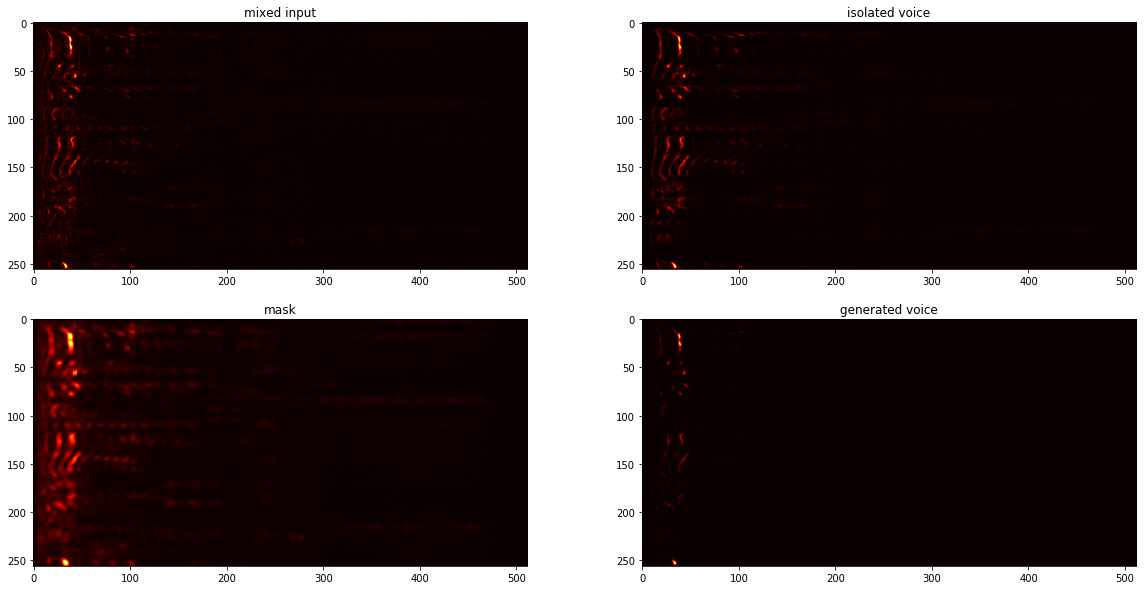

In [123]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
i = 0
ax[0,0].imshow(mix[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[i,:,:,0] * mask[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [124]:
mix_wave = []
voice_wave = []
gen_wave = []

for i in range(mix.shape[0]):
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    voice_wave.append(af.spectrogramToAudioFile(np.squeeze(voice[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    gen_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :] * mask[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))

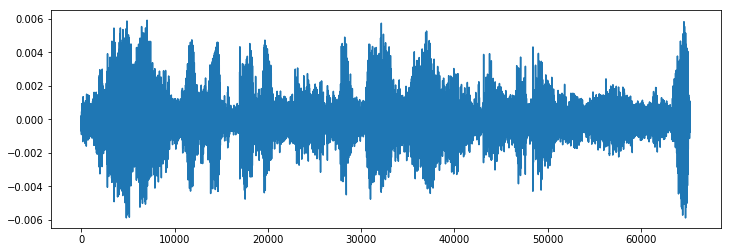

In [125]:
i=0
#  The original mixture
plt.figure(figsize=(12,4))
x = range(len(mix_wave[i]))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i], rate=sample_rate)

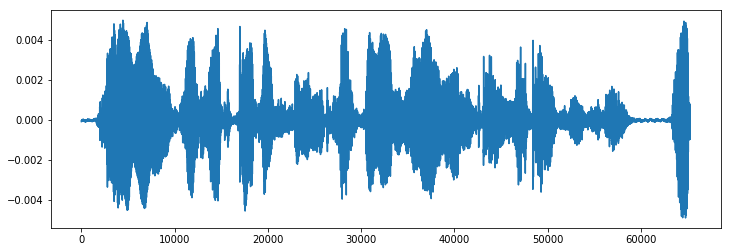

In [126]:
#  The isolated voice
plt.figure(figsize=(12,4))
x = range(len(voice_wave[i]))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i], rate=sample_rate)

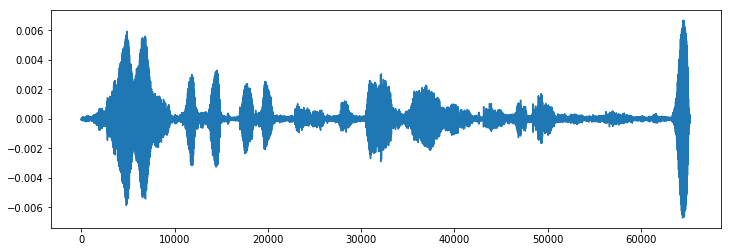

In [127]:
#  The model output
plt.figure(figsize=(12,4))
x = range(len(gen_wave[i]))
plt.plot(x,gen_wave[i])
ipd.Audio(gen_wave[i], rate=sample_rate)

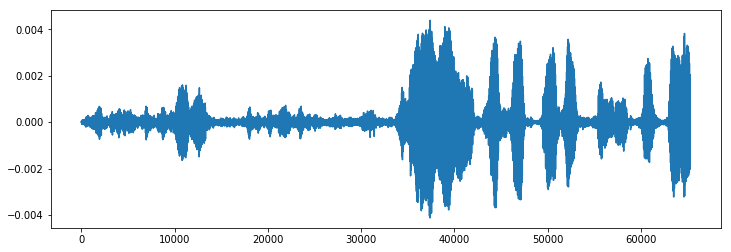

In [ ]:
plt.imshow(mask[4,:,:,0])
plt.show()

In [ ]:
mix[0,:,:,0] * mask[0,:,:,0]

In [ ]:
voice[0,:,:,0]

In [41]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
m_mag, v_mag = sess.run([mixed_mag, voice_mag])

In [44]:
mask = v_mag > 2e-02
masked_mix = m_mag.copy()
masked_mix[mask == 0] = 0

Text(0.5, 1.0, 'Masked Mixture Magnitude Spectrogram')

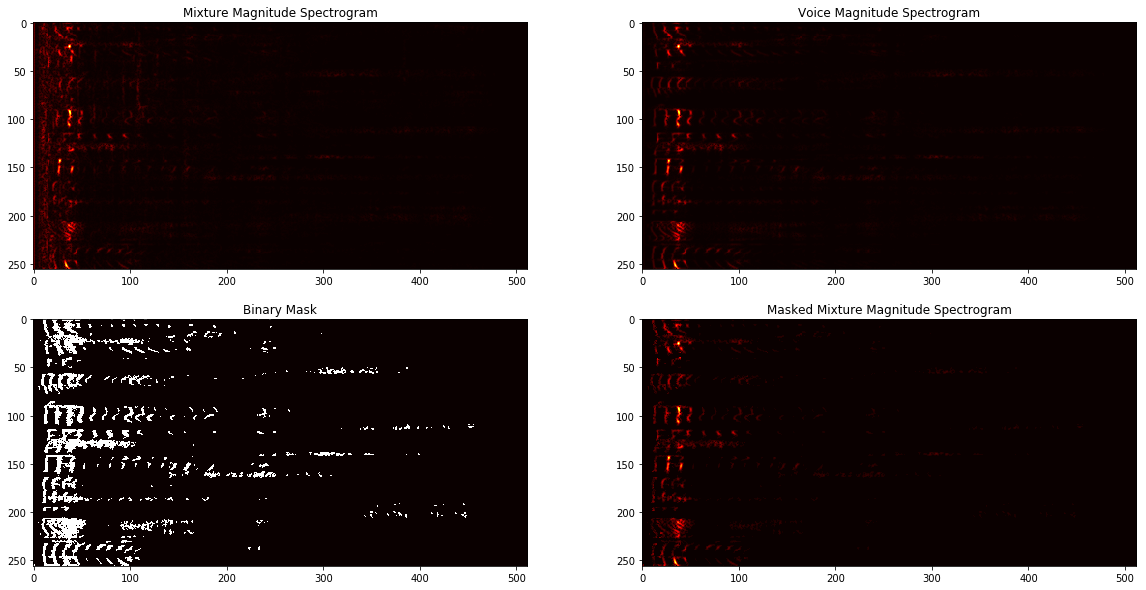

In [45]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(m_mag[0,:,:,0])
ax[0,0].set_title('Mixture Magnitude Spectrogram')
ax[0,1].imshow(v_mag[0,:,:,0])
ax[0,1].set_title('Voice Magnitude Spectrogram')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('Binary Mask')
ax[1,1].imshow(masked_mix[0,:,:,0])
ax[1,1].set_title('Masked Mixture Magnitude Spectrogram')

In [106]:
class alt_CapsUNetEncoder(object):
    """
    The down-convolutional side of a capsule based U-Net model (based on SegCaps R3 model).
    """
    def __init__(self, input_tensor, is_training, reuse):
        #net = layers.Input(shape=input_tensor)
        net = input_tensor
        with tf.variable_scope('Encoder'):
            with tf.variable_scope('Convolution'):
                # Layer 1: A conventional Conv2D layer
                net = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(net)

                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = net.get_shape()
                net = layers.Reshape((H.value, W.value, 1, C.value))(net)
                self.conv1 = net

            with tf.variable_scope('Primary_Caps'):
                # Layer 1: Primary Capsule: Conv cap with routing 1
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=16, strides=2, padding='same',
                                                    routings=1, name='primarycaps')(net)
                self.primary_caps = net

            with tf.variable_scope('Conv_caps_2'):
                # Layer 2: Convolutional Capsules
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1, padding='same',
                                                      routings=3, name='conv_cap_2_1')(net)
                self.conv_cap_2_1 = net

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=2, padding='same',
                                                      routings=3, name='conv_cap_2_2')(net)
                self.conv_cap_2_2 = net

            with tf.variable_scope('Conv_caps_3'):
                # Layer 3: Convolutional Capsules
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                      routings=3, name='conv_cap_3_1')(net)
                self.conv_cap_3_1 = net

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=64, strides=2, padding='same',
                                                    routings=3, name='conv_cap_3_2')(net)
                self.conv_cap_3_2 = net

            with tf.variable_scope('Conv_caps_4'):
                # Layer 4: Convolutional Capsules
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                      routings=3, name='conv_cap_4_1')(net)

            self.output = net


class alt_CapsUNetDecoder(object):
    """
    The up-convolutional side of a capsule based U-Net model.
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('Decoder'):
            with tf.variable_scope('UpCaps_1'):
                    # Layer 1 Up: Deconvolutional capsules, skip connection, convolutional capsules
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=32, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_1_1')(net)
                self.upcap_1_1 = net

                net = layers.Concatenate(axis=-2, name='up_1')([net, encoder.conv_cap_3_1])

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=1,
                                                      padding='same', routings=3, name='deconv_cap_1_2')(net)
                self.upcap_1_2 = net

            with tf.variable_scope('UpCaps_2'):
                # Layer 2 Up: Deconvolutional capsules, skip connection, convolutional capsules
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=16, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_2_1')(net)
                self.upcap_2_1 = net

                net = layers.Concatenate(axis=-2, name='up_2')([net, encoder.conv_cap_2_1])

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1,
                                                      padding='same', routings=3, name='deconv_cap_2_2')(net)
                self.upcap_2_2 = net

            with tf.variable_scope('UpCaps_3'):
                # Layer 3 Up: Deconvolutional capsules, skip connection
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=16, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_3_1')(net)
                self.upcap_3_1 = net

                net = layers.Concatenate(axis=-2, name='up_3')([net, encoder.conv1])
            with tf.variable_scope('Reconstruction'):
                # Layer 4: Reconstruction - Convolutional Capsule: 1x1, 3x conventional Conv2D layers
                net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                      routings=3, name='seg_caps')(net)
                
                _, H, W, C, D = net.get_shape()
                
                net = layers.Reshape((H.value, W.value, D.value))(net)

                net = layers.Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='relu', name='recon_1')(net)

                net = layers.Conv2D(filters=128, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='relu', name='recon_2')(net)

                net = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='sigmoid', name='out_recon')(net)

            self.output = net